In [1]:
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# create the NLP-object
import spacy
nlp = spacy.load('en_core_web_lg')

## 1. Training and updating models
Here, the final chapter, which is about one of the most exciting aspects of modern NLP: training your own models! 

In this section, you'll learn about training and updating spaCy's neural network models and the data you need for it – focusing specifically on the named entity recognizer.
### 1.1. Theory.
#### Why updating the model?
Before we get starting with explaining how, it's worth taking a second to ask ourselves: 
- Why would we want to update the model with our own examples? 
- Why can't we just rely on pre-trained models? 

Statistical models make predictions based on the examples they were trained on.
- You can usually make the model more accurate by showing it examples from your domain. 
- You often also want to predict categories specific to your problem, so the model needs to learn about them. 

This is essential for text classification, very useful for entity recognition and a little less critical for tagging and parsing.

#### How training works?
>- Step 1. **Initialize** the model weights randomly with `nlp.begin_training`
>- Step 2. **Predict** a few examples with the current weights by calling `nlp.update`
>- Step 3. **Compare** the `prediction` with the true `label`.
>- Step 4. **Calculate** how to change current weights to improve the prediction.
>- Step 5. **Update** weights slightly.
>- Step 6. Come back step 2.

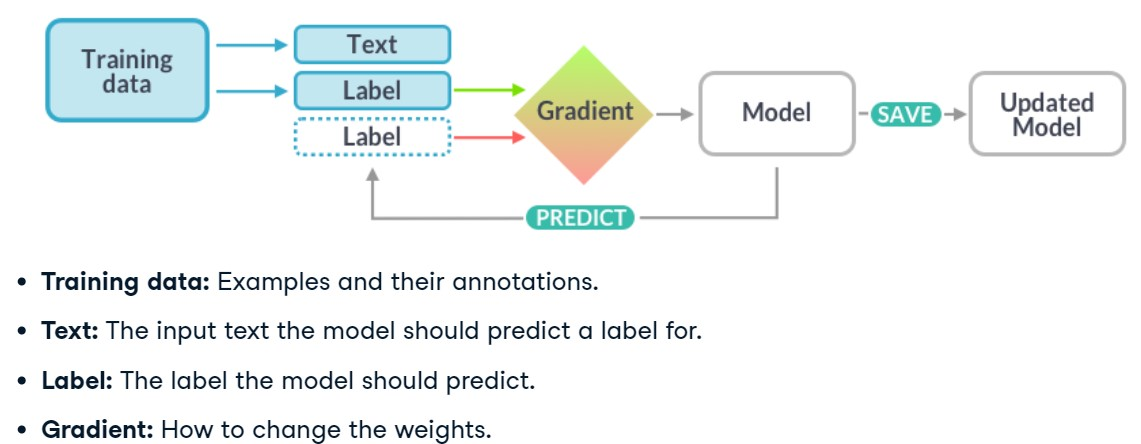

In [2]:
from IPython.display import Image
## Hình minh họa Image(fig1, height, width)

#### Example: Training the entity recognizer
Let's look at an example for a specific component: the entity recognizer.

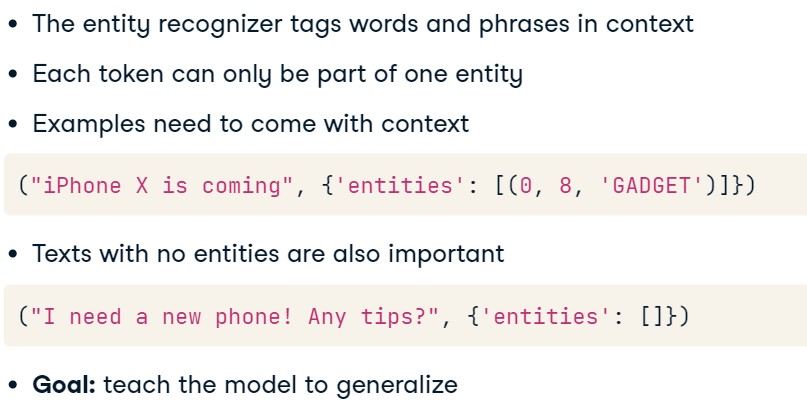

In [3]:
## Hình minh họa Image(fig1, height, width)

#### The training data
The training data tells the model what we want it to predict. This could be texts and named entities we want to recognize, or tokens and their correct part-of-speech tags. 

To **update an existing model**, we can start with a few hundred to a few thousand examples. 

To **train a new category** we may need up to a million. spaCy's pre-trained English models for instance were trained on 2 million words labelled with part-of-speech tags, dependencies and named entities. 

Training data is usually created by humans who assign labels to texts. This is a lot of work, but can be **semi-automated** – for example, using spaCy's Matcher.

### 1.2. PRACTICES
#### Exercise 1.2.1. Purpose of training
While spaCy comes with a range of pre-trained models to predict linguistic annotations, you almost always want to fine-tune them with more examples. You can do this by training them with more labelled data. **What does training not help with?**
>- Improve model accuracy on your data.
>- Learn new classification schemes.
>- Discover patterns in `unlabelled data`.

#### Answers.
>- A. Incorrect. If a `pre-trained model` doesn't perform well on your data, `training` it with more examples is often a good solution.
>- B. Incorrect. You can use training to teach the model `new labels`, entity types or other classification schemes.
>- C. **Correct!!**  `spaCy's components` are `supervised models` for text annotations, meaning they can only learn to reproduce examples, **not guess** `new labels` from raw text.

#### Exercise 1.2.2. Creating training data (1)
`spaCy's` rule-based Matcher is a great way to quickly create training data for named entity models. A list of sentences is available as the variable `TEXTS`. You can print it the IPython shell to inspect it. We want to find all mentions of different iPhone models, so we can create training data to teach a model to recognize them as `'GADGET'`.

The `nlp` object has already been created for you and the Matcher is available as the variable matcher.
#### SOLUTION.

In [4]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

# Two tokens whose lowercase forms match 'iphone' and 'x'
pattern1 = [{'LOWER': 'iphone'}, {'LOWER': 'x'}]

# Token whose lowercase form matches 'iphone' and an optional digit
pattern2 = [{'LOWER': 'iphone'}, {'IS_DIGIT': True,  # To find a digit token,  
                                  'OP': '?'}]        # To make a token optional, use the operator '?' 

# Add patterns to the matcher
matcher.add('GADGET', None, pattern1, pattern2)

#### Exercise 1.2.3. Creating training data (2)
Let's use the match patterns we've created in the previous exercise to bootstrap a set of training examples. 

The `nlp` object has already been created for you and the Matcher with the added patterns `pattern1` and `pattern2` is available as the variable matcher. 

In [5]:
TEXTS = ['How to preorder the iPhone X',
         'iPhone X is coming',
         'Should I pay $1,000 for the iPhone X?',
         'The iPhone 8 reviews are here',
         'Your iPhone goes up to 11 today',
         'I need a new phone! Any tips?']

A list of sentences is available as the variable `TEXTS`.
#### SOLUTION
**Step 1.**
>- Create a `doc` object for each text using `nlp.pipe` and find the matches in it.
>- Create a list of `(start, end, label)` tuples for the matches.

In [6]:
# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(TEXTS):
    # Find the matches in the doc
    matches = matcher(doc)
    
    # Get a list of (start, end, label) tuples of matches in the text
    entities = [(start, end, 'GADGET') for match_id, start, end in matches]
    print(doc.text, entities)    

How to preorder the iPhone X [(4, 6, 'GADGET'), (4, 5, 'GADGET')]
iPhone X is coming [(0, 2, 'GADGET'), (0, 1, 'GADGET')]
Should I pay $1,000 for the iPhone X? [(7, 9, 'GADGET'), (7, 8, 'GADGET')]
The iPhone 8 reviews are here [(1, 2, 'GADGET'), (1, 3, 'GADGET')]
Your iPhone goes up to 11 today [(1, 2, 'GADGET')]
I need a new phone! Any tips? []


**Step 2.**
>- Match on the `doc` and create a list of matched spans.
>- Format each example as a tuple of the `text` and a dict, mapping `'entities'` to the entity tuples.
>- Append the example to `TRAINING_DATA` and inspect the printed data.

In [7]:
TRAINING_DATA = []

# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(TEXTS):
    # Match on the doc and create a list of matched spans
    spans = [doc[start:end] for match_id, start, end in matcher(doc)]
    # Get (start character, end character, label) tuples of matches
    entities = [(span.start_char, span.end_char, 'GADGET') for span in spans]
    
    # Format the matches as a (doc.text, entities) tuple
    training_example = (doc.text, {'entities': entities})
    # Append the example to the training data
    TRAINING_DATA.append(training_example)
    
print(*TRAINING_DATA, sep='\n')    

('How to preorder the iPhone X', {'entities': [(20, 28, 'GADGET'), (20, 26, 'GADGET')]})
('iPhone X is coming', {'entities': [(0, 8, 'GADGET'), (0, 6, 'GADGET')]})
('Should I pay $1,000 for the iPhone X?', {'entities': [(28, 36, 'GADGET'), (28, 34, 'GADGET')]})
('The iPhone 8 reviews are here', {'entities': [(4, 10, 'GADGET'), (4, 12, 'GADGET')]})
('Your iPhone goes up to 11 today', {'entities': [(5, 11, 'GADGET')]})
('I need a new phone! Any tips?', {'entities': []})


## 2. The training loop
### 2.1. Theory
#### Step of training loop
>- Step 1. Loop for a number of time
>- Step 2. Shuffle the training data
>- Step 3. Divide the data into batches.
>- Step 4. Update the model for each batch.
>- Step 5. Save the updated model.

#### Recap: How training works?

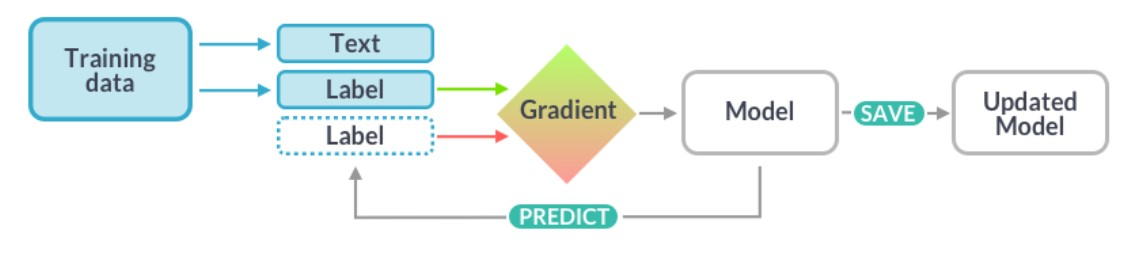

In [8]:
## Hình minh họa Image(fig1, height, width)

- The `training data` are the examples we want to update the model with. 
- The `text` should be a sentence, paragraph or longer document. For the best results, it should be similar to what the model will see at runtime. 
- The `label` is what we want the model to predict. This can be a text category, or an entity span and its type. 
- The `gradient` is how we should change the model to reduce the current error. It's computed when we compare the predicted label to the true label.

#### Example loop
Here's an example. Let's imagine we have a list of training examples consisting of texts and entity annotations. 
- We want to loop for 10 iterations, so we're iterating over a range of 10.
- Next, we use the random module to randomly shuffle the training data. 
- We then use spaCy's minibatch utility function to divide the examples into batches. 
- For each batch, we get the texts and annotations and call the nlp dot update method to update the model.
- Finally, we call the nlp dot to disk method to save the trained model to a directory.

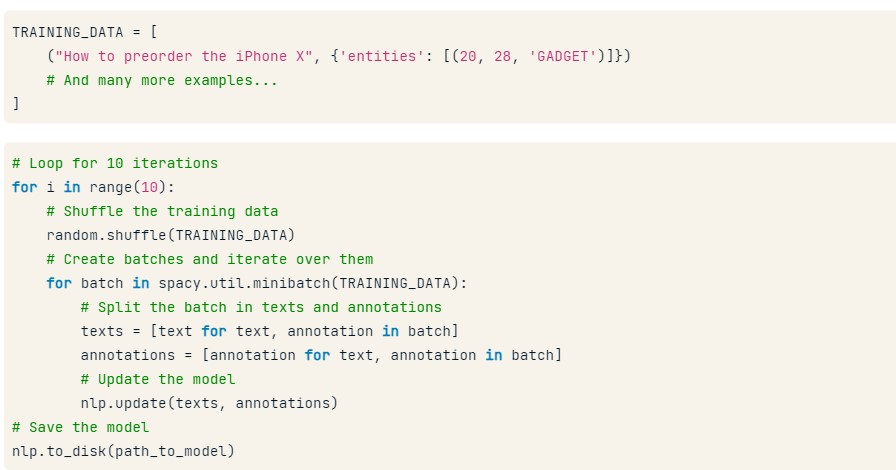

In [9]:
## Hình minh họa Image(fig1, height, width)

#### Updating an existing model
spaCy lets you update an existing pre-trained model with more data. For example, 
- To **improve its predictions** on different texts. This is especially useful if you want to improve categories the model already knows, like "person" or "organization". 
- You can also **update a model to add new categories**. Just make sure to always update it with examples of the new category and examples of the other categories it previously predicted correctly. Otherwise improving the new category might hurt the other categories.

#### Setting up a new pipeline from scratch
In this example, we start off with a blank English model using the spacy dot blank method. 
- The blank model doesn't have any pipeline components, only the language data and tokenization rules.
- We then create a blank entity recognizer and add it to the pipeline. 
- Using the `"add label" method`, we can add new string labels to the model. We can now call nlp dot begin training to initialize the model with random weights. 
- To get `better accuracy`, we want to loop over the examples more than once and randomly shuffle the data on each iteration.
- On each iteration, we divide the examples into batches using spaCy's minibatch utility function. Each example consists of a text and its annotations. 
- Finally, we update the model with the texts and annotations and continue the loop.

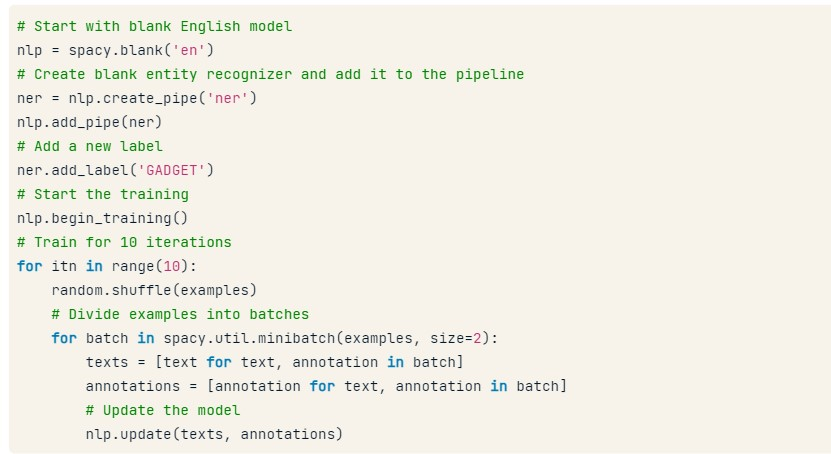

In [10]:
## Hình minh họa Image(fig1, height, width)

### 2.2. PRACTICES
#### Exercise 2.2.1. Setting up the pipeline
In this exercise, you'll prepare a spaCy pipeline to train the entity recognizer to recognize `'GADGET'` entities in a text – for exampe, "iPhone X".

spacy has already been imported for you.
#### SOLUTION.

In [11]:
# Create a blank 'en' model
nlp = spacy.blank('en')

# Create a new entity recognizer and add it to the pipeline
ner = nlp.create_pipe('ner')
nlp.add_pipe(ner)

# Add the label 'GADGET' to the entity recognizer
ner.add_label('GADGET')

#### Exercise 2.2.2. Building a training loop
Let's write a simple training loop from scratch!

The pipeline you've created in the previous exercise is available as the `nlp object`. It already contains the entity recognizer with the added label `'GADGET'`.

The small set of labelled examples that you've created previously is available as the global variable `TRAINING_DATA`. To see the examples, you can print them in your script or in the IPython shell. spacy and random have already been imported for you.
#### SOLUTION.

In [30]:
from numpy import random

L = iter(Losses)
# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in range(10):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}
    
    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=2):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]
        
        # Update the model
        nlp.update(texts, annotations, losses=losses)        
        print(losses)

{'ner': 11.199999451637268}
{'ner': 20.33886969089508}
{'ner': 31.41407334804535}
{'ner': 9.458550810813904}
{'ner': 14.576443016529083}
{'ner': 19.084092408418655}
{'ner': 1.814158096909523}
{'ner': 5.05903095472604}
{'ner': 8.310931246262044}
{'ner': 2.8253941372968256}
{'ner': 4.6078725308179855}
{'ner': 5.248786301643122}
{'ner': 3.1211183797568083}
{'ner': 5.196346546872519}
{'ner': 8.59970444010105}
{'ner': 1.1056318464688957}
{'ner': 3.2153938892297447}
{'ner': 4.962744418065995}
{'ner': 1.232489031739533}
{'ner': 1.5905362008826387}
{'ner': 1.8222667939190842}
{'ner': 1.13061572846712}
{'ner': 1.1462064740799462}
{'ner': 1.149261386070929}
{'ner': 0.0017659454157410437}
{'ner': 0.002059213171437424}
{'ner': 0.6201267141695239}
{'ner': 6.433389756921315e-05}
{'ner': 0.000102402174811278}
{'ner': 2.1697783428920245}


#### Exercise 2.2.3. Exploring the model
Let's see how the model performs on unseen data! 

To speed things up a little, here's a trained model for the label `'GADGET'`, using the examples from the previous exercise, plus a few hundred more. 

In [31]:
TEST_DATA = ['Apple is slowing down the iPhone 8 and iPhone X - how to stop it',
 "I finally understand what the iPhone X 'notch' is for",
 'Everything you need to know about the Samsung Galaxy S9',
 'Looking to compare iPad models? Here’s how the 2018 lineup stacks up',
 'The iPhone 8 and iPhone 8 Plus are smartphones designed, developed, and marketed by Apple',
 'what is the cheapest ipad, especially ipad pro???',
 'Samsung Galaxy is a series of mobile computing devices designed, manufactured and marketed by Samsung Electronics']

The loaded model is already available as the nlp object. A list of test texts is available as `TEST_DATA`.
#### SOLUTION.

In [34]:
# Process each text in TEST_DATA
for doc in nlp.pipe(TEST_DATA):
    # Print the document text and entitites
    print(doc.text)
    print(doc.ents, '\n\n')

Apple is slowing down the iPhone 8 and iPhone X - how to stop it
(iPhone 8, iPhone X)
I finally understand what the iPhone X 'notch' is for
(iPhone X,)
Everything you need to know about the Samsung Galaxy S9
(Samsung Galaxy,)
Looking to compare iPad models? Here’s how the 2018 lineup stacks up
(iPad, )
The iPhone 8 and iPhone 8 Plus are smartphones designed, developed, and marketed by Apple
(iPhone 8, iPhone 8)
what is the cheapest ipad, especially ipad pro???
(ipad, ipad)
Samsung Galaxy is a series of mobile computing devices designed, manufactured and marketed by Samsung Electronics
(Samsung Galaxy,)


## 3. Training best practices
### 3.1. Theory.
When you start running your own experiments, you might find that a lot of things just don't work the way you want them to. And that's okay. Training models is an iterative process, and you have to try different things until you find out what works best. 
 
Let's take a look at some of the problems you may come across.
#### Problem 1: Models can "forget" things
Statistical models can learn lots of things – but it doesn't mean that they won't unlearn them. If you're updating an existing model with new data, especially new labels, it can overfit and adjust *too much* to the new examples. 

For instance, if you're only updating it with examples of `"website"`, it may `"forget"` other labels it previously predicted correctly – like `"person"`. This is also known as the catastrophic forgetting problem.

#### Solution 1: Mix in previously correct predictions
To prevent this, make sure to always mix in examples of what the model previously got correct. If you're training a new category "website", also include examples of "person". 

`spaCy` can help you with this. You can create those additional examples by running the existing model over data and extracting the entity spans you care about. You can then mix those examples in with your existing data and update the model with annotations of all labels.

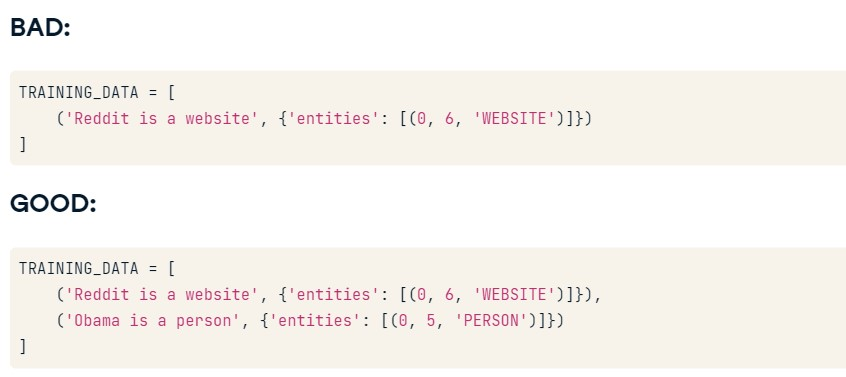

In [35]:
## Hình minh họa Image(fig1, height, width)

#### Problem 2: Models can't learn everything
Another common problem is that your model just won't learn what you want it to. spaCy's models make predictions based on the local context – for example, for named entities, the surrounding words are most important. If the decision is difficult to make based on the context, the model can struggle to learn it. The label scheme also needs to be consistent and not too specific. For example, it may be very difficult to teach a model to predict whether something is adult clothing or children's clothing based on the context. However, just predicting the label "clothing" may work better.

#### Solution 2: Plan your label scheme carefully
Before you start training and updating models, it's worth taking a step back and planning your label scheme. Try to pick categories that are reflected in the local context and make them more generic if possible. You can always add a rule-based system later to go from generic to specific. Generic categories like "clothing" or "band" are both easier to label and easier to learn.

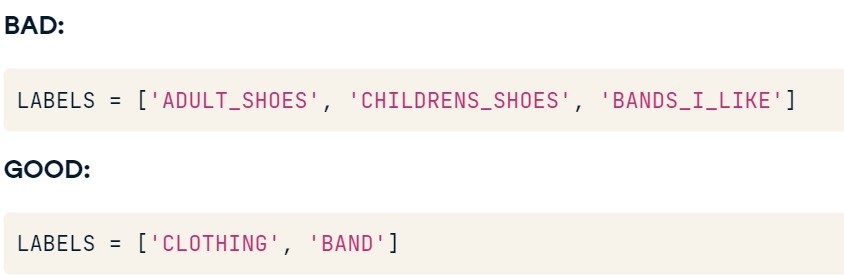

In [37]:
## Hình minh họa Image(fig1, height, width)

### 3.2. PRACTICES
#### Exercise 3.2.1. Good data vs. bad data
Here's an excerpt from a training set that labels the entity type `TOURIST_DESTINATION` in traveler reviews.

In [40]:
TOURIST_DESTINATION = [('i went to amsterdem last year and the canals were beautiful', {'entities': [(10, 19, 'TOURIST_DESTINATION')]}),
                        ('You should visit Paris once in your life, but the Eiffel Tower is kinda boring', {'entities': [(17, 22, 'TOURIST_DESTINATION')]}),
                        ("There's also a Paris in Arkansas, lol", {'entities': []}),
                        ('Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!', {'entities': [(0, 6, 'TOURIST_DESTINATION')]})]

Why is this data and label scheme problematic?

>- A. Whether a place is a tourist destination is a subjective judgement and not a definitive category. It will be very difficult for the entity recognizer to learn.
>- B. `"Paris"` and `"Arkansas"` should also be labelled as tourist destinations for consistency. Otherwise, the model will be confused.
>- C. Rare out-of-vocabulary words like the misspelled "amsterdem" shouldn't be labelled as entities.

#### Answers.
>- **A. Correct!!**
>- B. Incorrect. While it's possible that Paris, AK is also a tourist attraction, this only highlights how subjective the label scheme is and how difficult it will be to decide whether the label applies or not. As a result, this distinction will also be very difficult to learn for the entity recognizer.
>- C. Incorrect. Even very uncommon words or misspellings can be labelled as entities. In fact, being able to predict categories in misspelled text based on the context is one of the big advantages of statistical named entity recognition.

#### Exercise 3.2.2. Good & bad data.
- Rewrite the `TRAINING_DATA` to only use the label `GPE` (cities, states, countries) instead of `TOURIST_DESTINATION`.
- Don't forget to add tuples for the GPE entities that weren't labeled in the old data.

In [41]:
TRAINING_DATA = [
    ("i went to amsterdem last year and the canals were beautiful", {'entities': [(10, 19, 'GPE')]}),
    ("You should visit Paris once in your life, but the Eiffel Tower is kinda boring", {'entities': [(17, 22, 'GPE')]}),
    ("There's also a Paris in Arkansas, lol", {'entities': [(15, 20, 'GPE'), (24, 32, 'GPE')]}),
    ("Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!", {'entities': [(0, 6, 'GPE')]})
]

print(*TRAINING_DATA, sep='\n')

('i went to amsterdem last year and the canals were beautiful', {'entities': [(10, 19, 'GPE')]})
('You should visit Paris once in your life, but the Eiffel Tower is kinda boring', {'entities': [(17, 22, 'GPE')]})
("There's also a Paris in Arkansas, lol", {'entities': [(15, 20, 'GPE'), (24, 32, 'GPE')]})
('Berlin is perfect for summer holiday: lots of parks, great nightlife, cheap beer!', {'entities': [(0, 6, 'GPE')]})


**Comments.**

Once the model achieves good results on detecting GPE entities in the traveler reviews, you could add a rule-based component to determine whether the entity is a tourist destination in this context.

For example, you could resolve the entities types back to a knowledge base or look them up in a travel wiki.

#### Exercise 3.2.3. Training multiple labels
Here's a small sample of a dataset created to train a new entity type `WEBSITE`. 

The original dataset contains a few thousand sentences. 

In this exercise, you'll be doing the labeling by hand. In real life, you probably want to automate this and use an annotation tool – for example, Brat, a popular open-source solution, or Prodigy, our own annotation tool that integrates with spaCy.

In [42]:
TRAINING_DATA = [
    ("Reddit partners with Patreon to help creators build communities", 
     {'entities': [(0, 6, 'WEBSITE'), (21, 28, 'WEBSITE')]}),
  
    ("PewDiePie smashes YouTube record", 
     {'entities': [(18, 25, 'WEBSITE')]}),
  
    ("Reddit founder Alexis Ohanian gave away two Metallica tickets to fans", 
     {'entities': [(0, 6, 'WEBSITE')]}),
    # And so on...
]

**Step 2.** A model was trained with the data you just labelled, plus a few thousand similar examples. After training, it's doing great on WEBSITE, but doesn't recognize PERSON anymore. Why could this be happening?

>- A. It's very difficult for the model to learn about different categories like `PERSON` and `WEBSITE`.
>- B. The training data included no examples of `PERSON`, so the model learned that this label is incorrect.
>- C. The hyperparameters need to be retuned so that both entity types can be recognized.

#### Answers.
>- A. Incorrect. It's definitely possible for a model to learn about very different categories. For example, spaCy's pre-trained English models can recognize persons, but also organizations or percentages.
>- **B. Correct!!**
>- C. Incorrect. While the hyperparameters can influence a model's accuracy, they're likely not the problem here.

**Step 3.** Update the training data to include annotations for the PERSON entities `"PewDiePie"` and `"Alexis Ohanian"`.

            TRAINING_DATA = [
                ("Reddit partners with Patreon to help creators build communities", 
                 {'entities': [(0, 6, 'WEBSITE'), (21, 28, 'WEBSITE')]}),

                ("PewDiePie smashes YouTube record", 
                 {'entities': [____, (18, 25, 'WEBSITE')]}),

                ("Reddit founder Alexis Ohanian gave away two Metallica tickets to fans", 
                 {'entities': [(0, 6, 'WEBSITE'), ____]}),
                # And so on...
            ]

In [43]:
TRAINING_DATA = [
    ("Reddit partners with Patreon to help creators build communities", 
     {'entities': [(0, 6, 'WEBSITE'), (21, 28, 'WEBSITE')]}),
  
    ("PewDiePie smashes YouTube record", 
     {'entities': [(0, 9, 'PERSON'), (18, 25, 'WEBSITE')]}),
  
    ("Reddit founder Alexis Ohanian gave away two Metallica tickets to fans", 
     {'entities': [(0, 6, 'WEBSITE'), (15, 29, 'PERSON')]}),
    # And so on...
]